In [9]:
import numpy as np
from scipy import sparse
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Matrixverschiebungsmethode 1D

In [10]:
nodes = np.array([0,2,4,6,8])

#node1, node2, stiffness
elems = [(0,2, 1),
         (0,1, 3),
         (1,2, 3),
         (1,3, 2),
         (0,3, 2.5),
         (3,4, 6),
         (2,4, 2)]

C = np.array([1,2,3,2,2.5,6,2])*10**3

## Displacement boundary conditions

In [11]:
RBU = [(0,0.0)]

RBU = sorted(RBU, key = lambda b : b[0])

idxU = np.array([bc[0] for bc in RBU],dtype=int)
rbU = np.array([bc[1] for bc in RBU],dtype=float)

## Force boundary conditions

In [12]:
RBF = [(len(nodes)-1,5)]
RBF = sorted(RBF, key = lambda b : b[0])
idxF = np.array([bc[0] for bc in RBF],dtype=int)
rbF = np.array([bc[1] for bc in RBF],dtype=float)

## Stiffness Matrix

In [13]:
N = len(nodes)
Kges = np.zeros([N,N])
for n in range(len(elems)):
    Be = np.zeros(N)
    start = elems[n][0]
    end = elems[n][1]
    Be[start] = -1
    Be[end] = 1
    Ke = elems[n][2] * np.outer(Be, Be.T)
    Kges += Ke
Kges

array([[ 6.5, -3. , -1. , -2.5,  0. ],
       [-3. ,  8. , -3. , -2. ,  0. ],
       [-1. , -3. ,  6. ,  0. , -2. ],
       [-2.5, -2. ,  0. , 10.5, -6. ],
       [ 0. ,  0. , -2. , -6. ,  8. ]])

## Modified system of equations

$
L_{mod} \theta_{mod} = rhs_{mod}
$



### Reminder: 
$
L_F^T F - L_F^T K L_E d_E = L_F^T K L_F d_F 
$

### Generate paritioning matrices $L_E$ and $L_F$
(Transposed, for efficient construction using LIL-Matrices)

In [14]:
N = len(nodes)
Nf = N - len(idxU)
Ne = len(idxU)

LfT = sparse.lil_matrix((Nf,N),dtype='i')
LeT = sparse.lil_matrix((Ne,N),dtype='i')

n_LfT, n_LeT = 0,0
for i in range(N):
        if not i in idxU:
            LfT[n_LfT,i] = 1
            n_LfT += 1
        else:
            LeT[n_LeT,i] = 1
            n_LeT += 1

        
LfT = LfT.tocsr()
Lf = LfT.T
LeT = LeT.tocsr()
Le = LeT.T

print(LfT.todense())
print(Le.todense())

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
[[1]
 [0]
 [0]
 [0]
 [0]]


$
- \Delta \theta_{boundary} =  - L_F^T K L_E \theta_{mod} =  - L_F^T K \theta
$



$
\tilde{\theta} = L_{mod} \theta_{mod} = \left( L_F^T L L_F^T \right) \theta_{mod} = \left( L_F^T L L_F^T \right) \left( L_F^T \theta \right) 
$ 

In [15]:
LfTf = np.array([0,0,0,5])

rhs = LfTf - LfT @ Kges @ Le @ rbU

uf = solve(LfT @ Kges @ Lf, rhs)
u = Le @ rbU + Lf @ uf

fe = LeT @ Kges @ Le @ rbU + LeT @ Kges @ Lf @ uf
f = Le @ fe + Lf @ LfTf
f

print(u)
print(f)

[0.         0.55509868 0.80592105 1.01151316 1.58511513]
[-5.  0.  0.  0.  5.]


[(0.0, 1, -0.49999999999999983, 0), (9.585115131578947, 1, 0.5, 0)]


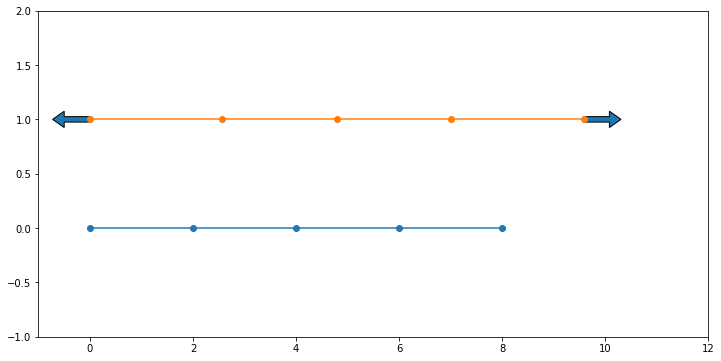

In [33]:
%matplotlib inline

origx = nodes
origy = [0] * len(nodes)

defx = nodes + u
defy = [1] * len(defx)

# force arrows
arrows = []
scale = 0.1
for n in range(len(f)):
    if not f[n] == 0:
        x,y = defx[n], 1
        dx,dy = f[n]*scale, 0
        arrows.append((x,y,dx,dy))

print(arrows)


    
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(origx,origy, marker="o", )
ax.plot(defx,defy, marker="o", )
for ar in arrows:
    ax.arrow(*ar, width = 0.05)
ax.set_ylim((-1,2))
ax.set_xlim((-1,12))
plt.show()